In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (에러 시 생략 가능)
plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# ✅ 라이브러리 임포트
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

from modules.preprocess_cols import (
    preprocess_telco_columns,
    add_derived_features,
    scale_numeric_features,
    load_model_with_assets
)

# ✅ 1. 데이터 불러오기
df_raw = pd.read_csv('../00.data/telco.csv')

# ✅ 2. 전처리
df_proc, _ = preprocess_telco_columns(df_raw)
df_proc = add_derived_features(df_proc)

# ✅ 3. 저장된 모델에서 사용 피처, 스케일러 로드
bundle = load_model_with_assets()
features = bundle['features']
scaler = bundle['scaler']

# ✅ 4. 스케일링
numeric_cols = df_proc.select_dtypes(include=['float64', 'int64']).columns.difference(['Churn']).tolist()
df_proc, _ = scale_numeric_features(df_proc, numeric_cols, scaler=scaler)

# ✅ 5. 데이터 분리
X = df_proc[features]
y = df_proc["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ✅ 6. 의사결정트리 모델 학습
tree_model = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=50,
    random_state=42
)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=50, random_state=42)

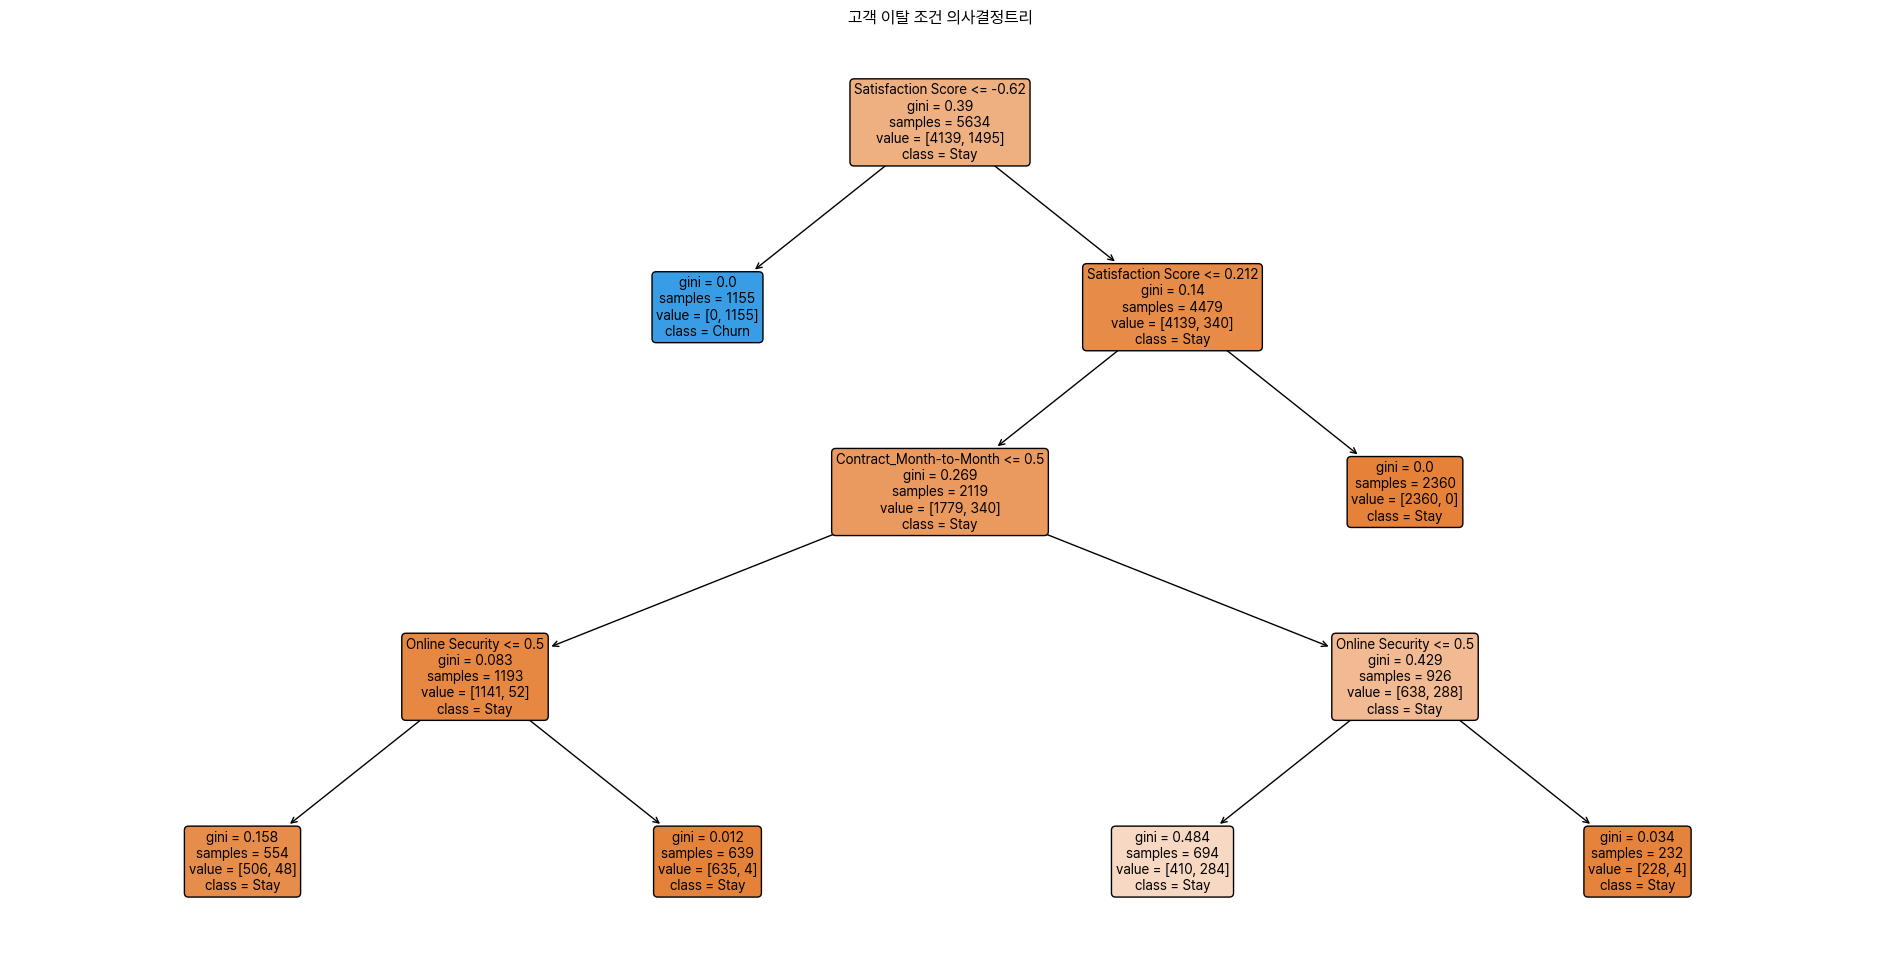

In [5]:
# ✅ 7. 트리 시각화
plt.figure(figsize=(24, 12))
plot_tree(
    tree_model,
    feature_names=X_train.columns,
    class_names=["Stay", "Churn"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("고객 이탈 조건 의사결정트리")
plt.show()

### ✅ 주요 분기 흐름 정리

| 분기 조건                                     | 샘플 수  | 이탈율                 | 해석                                 |
| ----------------------------------------- | ----- | ------------------- | ---------------------------------- |
| `Satisfaction Score ≤ -0.62`              | 1,155 | 100%                | 절대적 이탈 조건. **즉시 리텐션 개입 필요**        |
| `Satisfaction Score > -0.62 and ≤ -0.212` | 2,479 | 13.7% (340/2479)    | **중간 만족도** 수준 → 계약/보안 여부에 따라 추가 분기 |
| `Contract_Month-to-Month == 1`            | 694   | **41%** (284/694)   | 단기 계약 고객은 이탈률 상승                   |
| `Online Security == 0` (보안 미이용자)          | 926   | **31.1%** (288/926) | 보안 서비스 미가입자 이탈률 ↑                  |


### ✅ 리텐션 전략 도출 (분기 기반)

| 조건 조합                       | 타겟 전략                                    |
| --------------------------- | ---------------------------------------- |
| **만족도 -0.62 이하**            | 즉각적 이탈 유도 조건 → 리텐션 전용 UX 필요 (설문 + 혜택 제시) |
| **중간 만족도 + 월별 계약 + 보안 미가입** | 행동 기반 이탈 위험군 → 보안 서비스 추천, 장기 약정 유도 프로모션  |
| **고 만족도 + 보안 가입 + 연간 계약**   | 안정적 고객군 → CLTV 상승 유도를 위한 리워드 전략 고려       |

| “만족도 점수가 매우 낮으면 무조건 이탈한다.”
“만족도가 중간인 고객도 단기 계약 + 보안 미가입이면 이탈 위험이 올라간다.”